# Load Library & Preprocess Data

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

import posenet

from config import *
from Datagenerator.Dataloader import load_data
from Datagenerator.Datagenerator import *
from Utils.draw_utils import *
from Utils.evaluate import evaluate
from Decode.decode_utils import *
from Decode.Decoder import *
from Losses.loss import *

### Set Seed

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

### Load Data 

In [3]:
df = load_data()
print(len(df))
df.head()

16816


,NAME,pelvis_X,pelvis_Y,r hip_X,r hip_Y,r knee_X,r knee_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,610,187,573,185,616,269,620,394,647,188,661,221,656,231,628,181,647,176,637.0201,189.8183,695.9799,108.1817,692,185,693,240,688,313,601,167,553,161,606,217
1,../../Datasets/mpii_human_pose_v1/images/01559...,763,568,806,543,-1,-1,-1,-1,720,593,-1,-1,-1,-1,723,429,683,290,682.0000,256.0000,676.0000,68.0000,719,299,711,516,545,466,647,281,555,410,563,296
2,../../Datasets/mpii_human_pose_v1/images/00580...,974,446,908,438,816,510,804,711,1040,454,906,528,883,707,979,349,985,253,982.7591,235.9694,962.2409,80.0306,1067,253,1167,353,1142,478,902,253,798,340,869,214
3,../../Datasets/mpii_human_pose_v1/images/08661...,248,341,201,340,305,375,301,461,294,342,335,370,331,455,263,302,279,263,277.0210,268.7786,305.9790,184.2214,314,264,327,320,362,346,244,261,260,335,328,354
4,../../Datasets/mpii_human_pose_v1/images/06011...,904,237,865,248,896,318,980,322,943,226,948,290,881,349,881,186,858,135,871.1877,180.4244,835.8123,58.5756,923,123,995,163,961,223,792,147,754,247,772,294


### Split train & test Data 

In [4]:
train_df, validation_df = train_test_split(df, test_size=0.3, random_state=SEED)

# Build Model

In [5]:
with tf.device('/device:GPU:0'):
    base_model = posenet.load_model(mode)
    inputs = tf.keras.Input(shape=(256,256,3))
    outputs = base_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile Model

### Compile 

In [6]:
model.compile(
     optimizer = optimizer,
    # loss = [tf.keras.losses.MeanAbsoluteError(),
    #        tf.keras.losses.MeanAbsoluteError()],
    # loss = [AdaptiveSwingLoss, criterion],
    # loss = [criterion2, criterion],
    loss = [criterion2, tf.keras.losses.MeanAbsoluteError()],
    loss_weights = loss_weight,
)

# Training 

In [7]:
train_gen = DataGenerator(
    list_IDs = train_df.index,
    df = df,
    batch_size = batch_size,
    shuffle = True,
    image_paths = train_df['NAME'],
    mode = 'fit',
)

val_gen = DataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = batch_size,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

ckpt = ModelCheckpoint(
    # filepath = f'./checkpoints/{ckpt_path}.hdf5',
    filepath = f'./checkpoints/{ckpt_path}.hdf5',
    monitor = 'loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto'
)

reducelr = ReduceLROnPlateau(
    monitor = 'loss',
    factor = .25,
    patience = 2,
    min_lr = 1e-5,
    verbose = 1,
)

In [8]:
history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    callbacks = [reducelr, ckpt],
    use_multiprocessing = False,
)

1471/1471 [==============================] - ETA: 0s - loss: 2.0691 - mobile_net_v1_loss: 9.9010e-04 - mobile_net_v1_1_loss: 1.0790
Epoch 00001: loss improved from inf to 2.06906, saving model to ./checkpoints/20200816_more_deep_layer_with-graph.h5
1471/1471 [==============================] - 385s 262ms/step - loss: 2.0691 - mobile_net_v1_loss: 9.9010e-04 - mobile_net_v1_1_loss: 1.0790 - val_loss: 5.6743 - val_mobile_net_v1_loss: 0.0045 - val_mobile_net_v1_1_loss: 1.1711


# History 

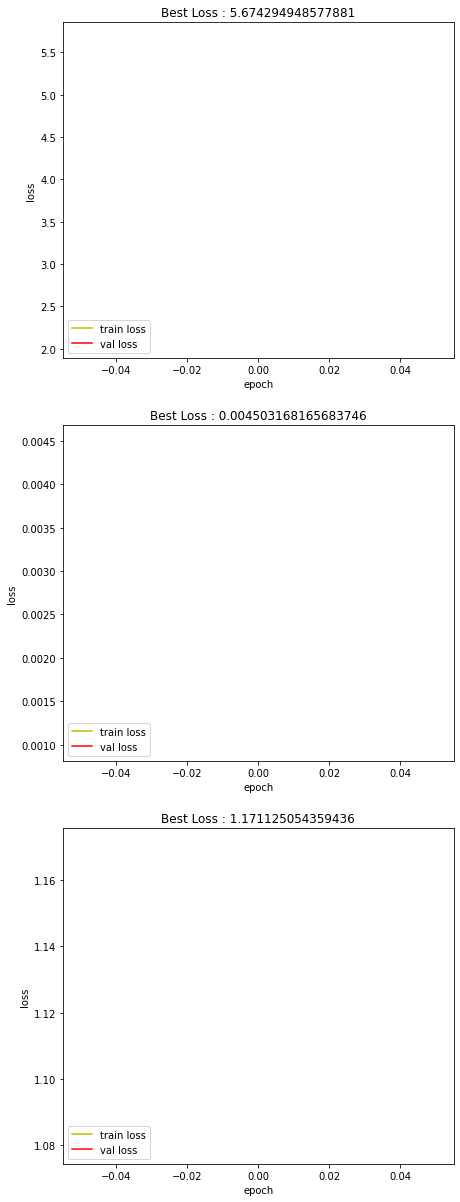

In [9]:
draw_train_result(history)

# Inference 

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
with tf.device('/device:GPU:1'):
    base_model = posenet.load_model(mode)
    inputs = tf.keras.Input(shape=(256,256,3))
    outputs = base_model(inputs)
    inf_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    inf_model.load_weights(f'./checkpoints/{ckpt_path}.hdf5')

In [ ]:
# decode_model = add_decoder(inf_model)

In [13]:
inf_gen = EvalDataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = 1,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

In [14]:
img, regr = inf_gen.__getitem__(11)
result = inf_model(img)
idx = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


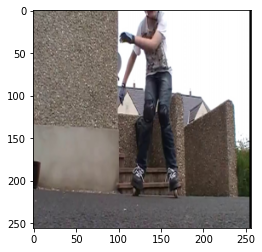

In [15]:
plt.imshow(img[idx])
plt.show()

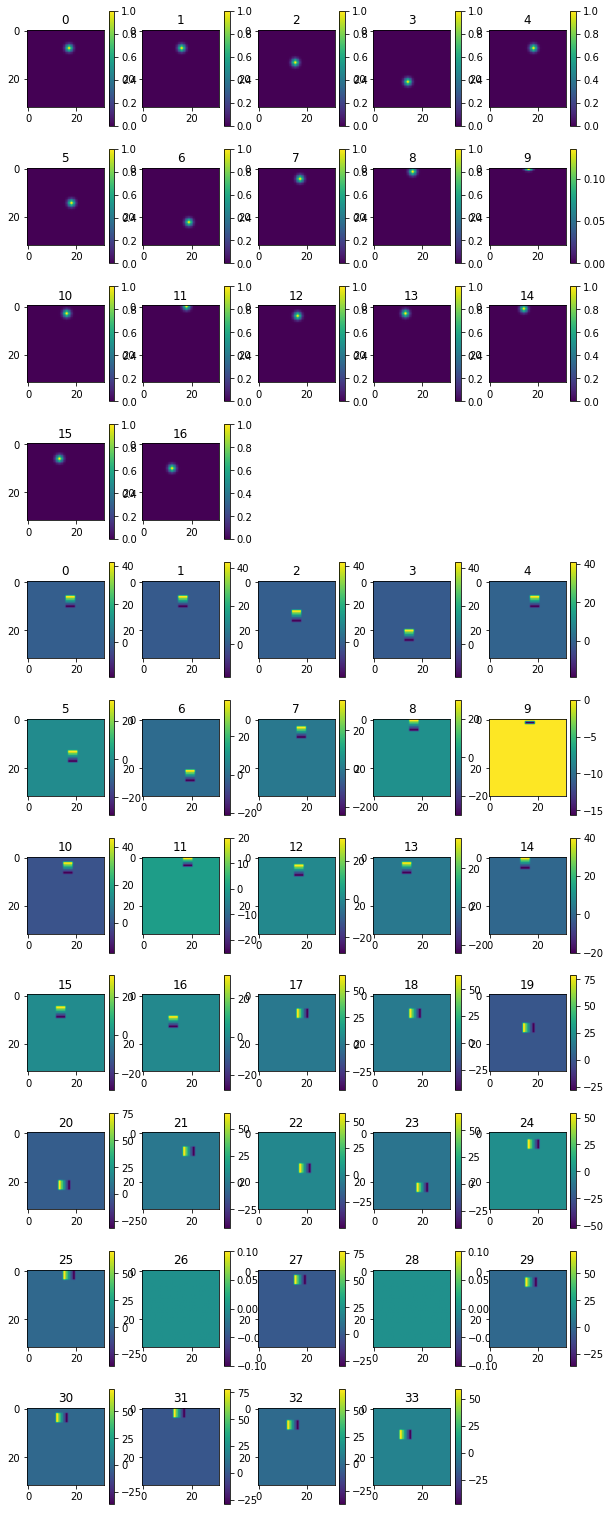

In [16]:
draw_heatmap(0, *regr)

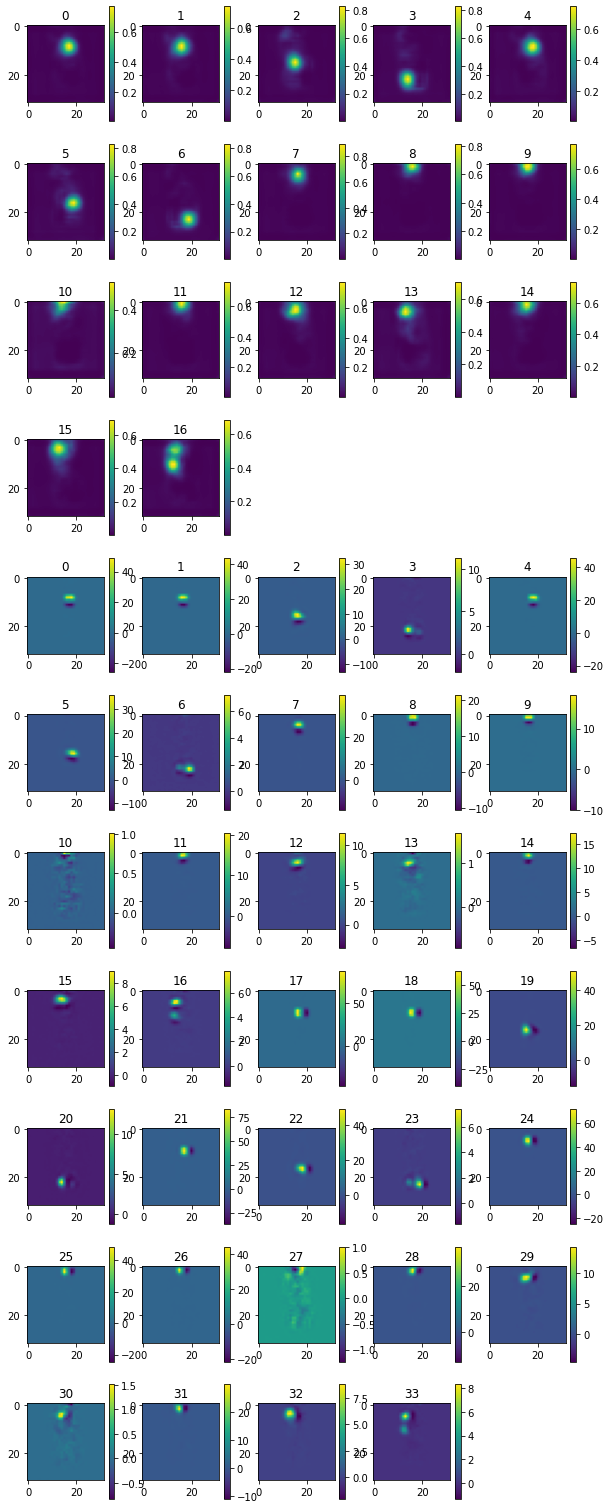

In [17]:
draw_heatmap(0, heatmap_result=result[0], offset_result=result[1])

# Decode 

In [18]:
pose_scores, keypoint_scores, keypoint_coords = decode_single_poses(result[0].numpy().squeeze(axis=0),
                    result[1].numpy().squeeze(axis=0))

print(f'pose score : {pose_scores}')
print(f'keypoint scores :')
print(f'{keypoint_scores}')
print(f'keypoint coords :')
print(f'{keypoint_coords}')

pose score : [0.7538732290267944]
keypoint scores :
[0.77579516 0.73788947 0.82821321 0.82858914 0.7462002  0.82740462
 0.82962269 0.8949793  0.81462198 0.76426864 0.52658224 0.76263583
 0.77815908 0.70558542 0.73450178 0.69130898 0.56948715]
keypoint coords :
[[109.38786697 181.38786697]
 [107.51638794 171.51638794]
 [149.57175446 149.57175446]
 [186.51443577 122.51443577]
 [109.98152924 189.98152924]
 [163.97174454 187.97174454]
 [190.23532438 158.23532438]
 [ 71.30288315 167.30288315]
 [ 27.52980614 147.52980614]
 [ 25.74596977 137.74596977]
 [  1.00458968 121.00458968]
 [ 14.83067894 142.83067894]
 [ 31.35357952 127.35357952]
 [ 33.07901251 105.07901251]
 [ 20.81149101 132.81149101]
 [ 32.22367096 112.22367096]
 [ 39.31996727 111.31996727]]


In [19]:
pose_scores_nooff, keypoint_scores_nooff, keypoint_coords_nooff = decode_single_poses_nooff(result[0].numpy().squeeze(axis=0),
                    result[1].numpy().squeeze(axis=0))

print(f'pose score nooff: {pose_scores_nooff}')
print(f'keypoint scores nooff:')
print(f'{keypoint_scores_nooff}')
print(f'keypoint coords nooff:')
print(f'{keypoint_coords_nooff}')

pose score nooff: [0.7538732290267944]
keypoint scores nooff:
[0.77579516 0.73788947 0.82821321 0.82858914 0.7462002  0.82740462
 0.82962269 0.8949793  0.81462198 0.76426864 0.52658224 0.76263583
 0.77815908 0.70558542 0.73450178 0.69130898 0.56948715]
keypoint coords nooff:
[[ 64. 136.]
 [ 64. 128.]
 [120. 120.]
 [176. 112.]
 [ 64. 144.]
 [128. 152.]
 [184. 152.]
 [ 32. 128.]
 [  8. 128.]
 [  8. 120.]
 [  0. 120.]
 [  0. 128.]
 [ 24. 120.]
 [ 32. 104.]
 [  8. 120.]
 [ 24. 104.]
 [ 32. 104.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


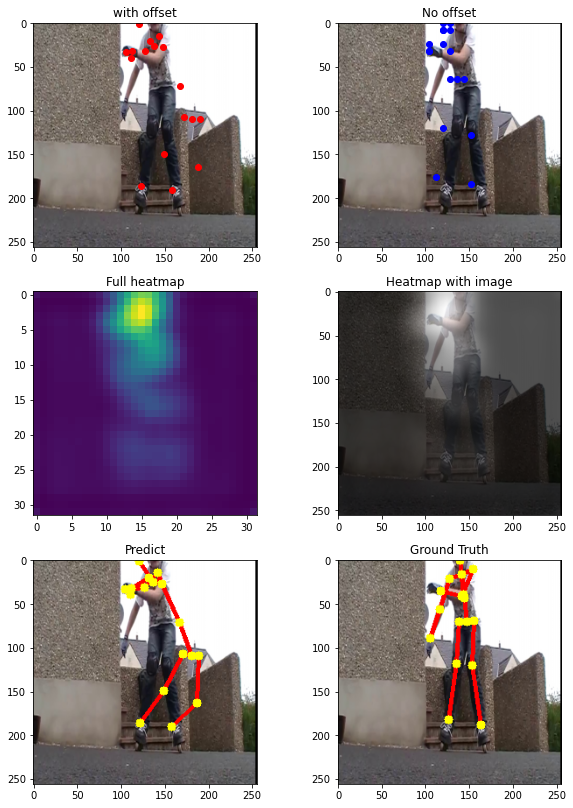

In [20]:
draw_result(img, idx, keypoint_coords, keypoint_coords_nooff, result, inf_gen)

# Evaluate

In [21]:
evaluate(inf_model, inf_gen)

100%|██████████| 5045/5045 [03:48<00:00, 22.07it/s]

Total accuracy : 0.08749489885151587
